# IM2ELEVATION Replication and Modification

This notebook is focused on replicating the IM2ELEVATION model and modifying it to fit the requirements of the project.

This is preceded by the sentinel_ump_dl notebook, which focuses on the breadth of fitting the data to various ML models and their comparisons.

This is superseded by the sentinel_ump_12ch notebook, which focuses on transfer learning on the same model that has been modified to work with all 12 channels of the sentinel image than just RGB.

### Setting up

In [1]:
# Ensures runtime code is updated when source code of libraries are updated as well
%load_ext autoreload
%autoreload 2

In [2]:
# Import of necessary libraries

import pandas as pd
import numpy as np
import pickle
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import ssl

# FastAI
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

import utils.sp_utils as sp


In [3]:
# User modules

from utils.models import senet
from utils.models import modules
from utils.models import net

In [4]:
# Check if gpu/cuda is available
import torch
torch.cuda.is_available()

True

In [5]:
# Constants
BANDS = [
        'B1: Aerosols',
        'B2: Blue',
        'B3: Green',
        'B4: Red',
        'B5: Red Edge 1',
        'B6: Red Edge 2',
        'B7: Red Edge 3',
        'B8: NIR',
        'B8A: Red Edge 4',
        'B9: Water Vapor',
        'B11: SWIR 1',
        'B12: SWIR 2'
    ]

UMP = ['height_avg_bld', 'height_avg_area', 'height_avg_total', 'height_std',
       'height_max', 'height_percentile', 'planar_index', 'frontal_index']

BATCH_SIZE = 64
CHECKPT_PATH = "pretrained_model/im2elevation/Block0_skip_model_110.pth.tar"

def calcRes(n, k, stride, pad):
    """
    Calculates the resolution of a square array after convolution

    # Parameters:\n
    - n: H/W of the input array\n
    - k: Filter H/W\n
    - stride: Convolution stride\n
    - pad: Padding around input array\n
    """

    return (n + 2*pad - k)//stride + 1

In [6]:
# Import train and validation
with open("data/x_train_tokyo.pkl", "rb") as f:
    x_train = pickle.load(f)

with open("data/x_val_tokyo.pkl", "rb") as f:
    x_val = pickle.load(f)

with open("data/y_train_tokyo.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("data/y_val_tokyo.pkl", "rb") as f:
    y_val = pickle.load(f)

print("Types:", x_train.dtype, x_train.dtype, x_val.dtype, y_val.dtype)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}\nx_val shape: {x_val.shape}, y_val shape: {y_val.shape}")

Types: float32 float32 float32 float32
x_train shape: (2628, 12, 91, 91), y_train shape: (2628, 8)
x_val shape: (614, 12, 91, 91), y_val shape: (614, 8)


### Checking for NaN values in input

In [7]:
np.isnan(x_train).sum(), np.isnan(x_val).sum(), np.isnan(y_train).sum(), np.isnan(y_val).sum()

(0, 0, 0, 0)

### Normalising x and y

Normalisation will only be fitted on the training set, and the same parameters will be used for the validation sets

In [8]:
class NDNormalizer:
    """
    Class that normalises the values from 0 - 255 to match the inputs that the original senet is trained on
    """
    def __init__(self, x):
        self.min_x = x.min()
        self.max_x = x.max()
    
    def transform(self, new_x):
        return (new_x / self.max_x) * 255

    def revert(self, new_x):
        return new_x * self.max_x / 255



In [9]:
x_norms = []
x_train_norm = np.array(x_train)
for channel in range(x_train.shape[1]):
    x_norms.append(NDNormalizer(x_train[:, channel]))
    # x_norms.append(MinMaxScaler().fit(x_train[:, channel]))
    x_train_norm[:, channel] = x_norms[channel].transform(x_train[:, channel])

In [10]:
y_norms = []
y_train_norm = np.array(y_train)
for ump in range(y_train.shape[1]):
    y_norms.append(NDNormalizer(y_train[:, ump]))
    y_train_norm[:, ump] = y_norms[ump].transform(y_train[:, ump])

In [11]:
for channel in range(12):
    # print("Channel", channel)
    # print(x_train[:, channel].min())
    print(x_train[:, channel].max(), end= ", ")

5232.0, 12216.0, 14792.0, 16032.0, 15665.0, 15742.0, 15663.0, 15607.0, 15569.0, 7385.0, 14959.0, 15063.0, 

### Loss Function and Metric

In [12]:
# Loss Function

def mse_weighted(pred, actual, y_norms:List[NDNormalizer]= y_norms):
    """
    Weighted loss function that normalises the predictions based on the parameters used to normalise the actual during training
    """
    loss = tensor(0).float()
    loss.requires_grad_(True)
    for ump in range(pred.shape[1]):
        # loss = torch.add(loss, F.mse_loss(pred[:, ump], actual[:, ump]))
        loss = torch.add(loss, torch.div(F.mse_loss(pred[:, ump], actual[:, ump]), y_norms[ump].max_x**2))
    if loss.isnan().sum() > 1:
        raise ValueError([pred, actual])
    return loss.float()


In [13]:
# List of metrics
def height_avg_bld_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 0], actual[:, 0]))

def height_avg_area_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 1], actual[:, 1]))

def height_avg_total_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 2], actual[:, 2]))

def height_std_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 3], actual[:, 3]))

def height_max_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 4], actual[:, 4]))

def height_percentile_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 5], actual[:, 5]))

def planar_index_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 6], actual[:, 6]))

def frontal_index_rmse(pred, actual):
    return math.sqrt(F.mse_loss(pred[:, 7], actual[:, 7]))

metrics = [
    height_avg_bld_rmse, 
    height_avg_area_rmse,
    height_avg_total_rmse,
    height_std_rmse,
    height_max_rmse,
    height_percentile_rmse,
    planar_index_rmse,
    frontal_index_rmse
]

### DataLoaders

In [14]:
# DataLoaders for 3 channels in gpu

# Converts into dataloaders
dls_3 = DataLoaders().from_dsets(list(zip(x_train[:, 1:4], y_train)), list(zip(x_val[:, 1:4], y_val)), 
    bs= BATCH_SIZE, device=torch.device('cuda'))

# Check shape
dls_3.one_batch()[0].shape, dls_3.one_batch()[1].shape

(torch.Size([64, 3, 91, 91]), torch.Size([64, 8]))

In [15]:
# DataLoaders for 12 channels in gpu
# Note that RGB are not together now


# Converts into dataloaders
dls_12 = DataLoaders().from_dsets(list(zip(x_train, y_train)), list(zip(x_val, y_val)), 
    bs= 8, device=torch.device('cuda'))

# Check shape
dls_12.one_batch()[0].shape, dls_12.one_batch()[1].shape

(torch.Size([8, 12, 91, 91]), torch.Size([8, 8]))

### Model using Imagenet weights

In [15]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# This is not ideal since we're only working with one feature but we'll try to make it work first
head = create_head(8, 8, ps=0.5)
original_model = senet.senet154()

# original_model = pretrainedmodels.__dict__["sene154"](num_classes=1000, pretrained='imagenet')
# original_model = xse_resnet18() # Check whether it lines up with the number of blockst too
Encoder = modules.E_senet(original_model, x_norms)
im2elevation = net.im2elevation_model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
model = net.model(im2elevation, head)


TypeError: __init__() missing 1 required positional argument: 'block_channel'

In [ ]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics)

SuggestedLRs(valley=0.0010000000474974513)

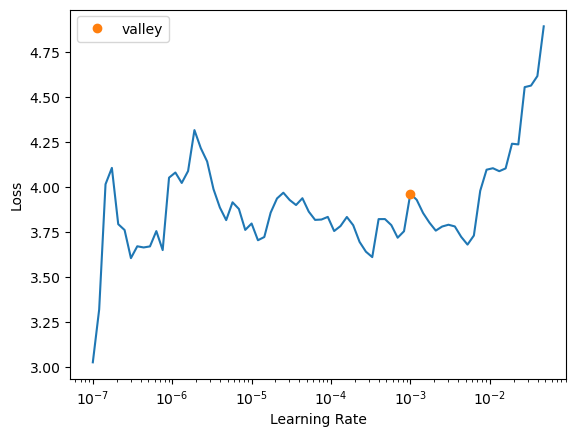

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.144768,8.236219,7.369600,13.272091,3.698546,21115.280269,52.596954,22.928037,0.778072,0.335740,01:51


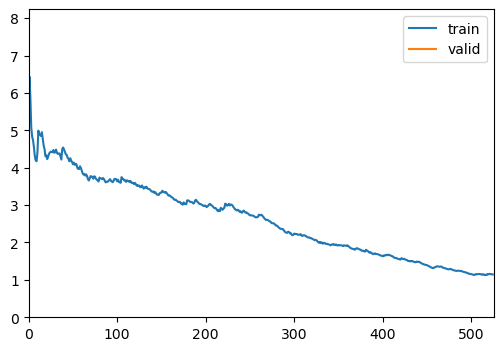

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.568570,442.486053,41.536142,42.047627,64.195717,21125.007656,127.565099,169.646370,7.989816,2.653468,01:50
1,0.363761,0.177102,5.231319,11.531877,2.013071,21115.693679,53.144155,22.759610,0.120176,0.131729,01:51
2,0.270457,10.115270,9.072717,24.612670,4.237441,21113.812658,54.661006,21.758470,0.140107,1.265921,01:50
3,0.216142,98.544357,9.248185,14.137300,9.029332,21113.023090,51.447716,31.924863,1.739937,1.016755,01:51
4,0.198586,2.016772,14.706294,19.925047,9.482035,21111.222480,55.682954,42.588120,0.258999,0.239409,01:51


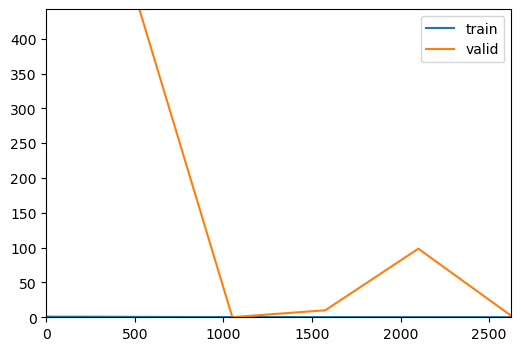

In [ ]:
learn.fine_tune(5, 0.001, cbs= [ShowGraphCallback()])

In [ ]:
# Garbage collection
try:
    del head
    del original_model
    del model
    del Encoder
    del learn
except:
    pass
gc.collect()

0

### Model using IM2ELEVATION weights

In [ ]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if "HARM" in layer.upper():
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias']


In [ ]:
# ssl to facilitate downloading of weights
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# This is not ideal since we're only working with one feature but we'll try to make it work first
head = create_head(1, 8, ps=0.5)
original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
im2elevation = net.im2elevation_model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# Load weights
im2elevation.load_state_dict(checkpoint["state_dict"])

# Clear memory
del checkpoint
gc.collect()

model = net.model(im2elevation, head)


In [ ]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics)

SuggestedLRs(valley=0.0006918309954926372)

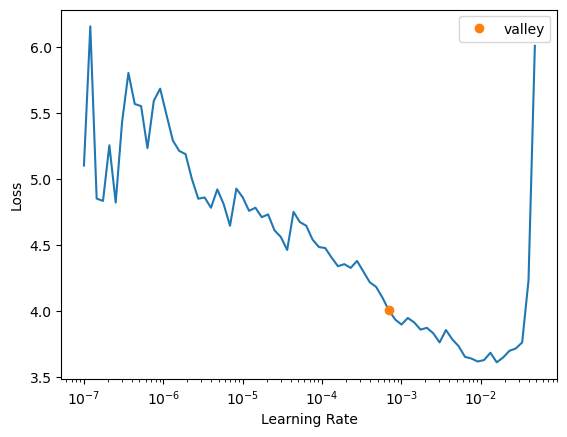

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.197157,0.205183,8.972118,14.552253,3.386079,21115.745692,56.541666,23.987065,0.122586,0.093377,01:49


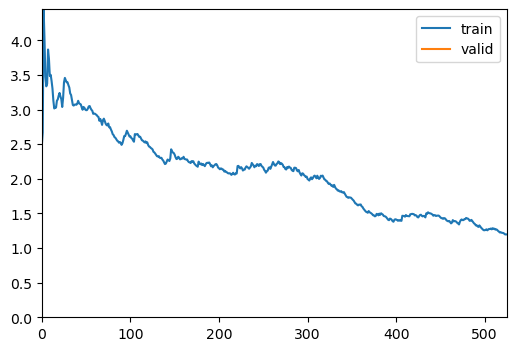

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.589979,0.161446,7.710722,11.793797,3.538952,21115.915900,51.436336,19.659477,0.115649,0.149907,01:49
1,0.393729,20.081944,8.179252,26.899431,9.459676,21120.860930,80.993407,32.362608,0.932181,0.657709,01:49
2,0.288193,0.112047,2.543584,8.246302,1.529171,21115.587687,48.684047,17.632258,0.094620,0.111989,01:49
3,0.245179,0.114938,1.801719,6.685369,1.884201,21115.656789,48.277370,16.040765,0.095696,0.108943,01:49
4,0.201782,0.086221,1.923818,6.852827,1.781015,21115.756557,49.908086,16.600140,0.074778,0.084466,01:49


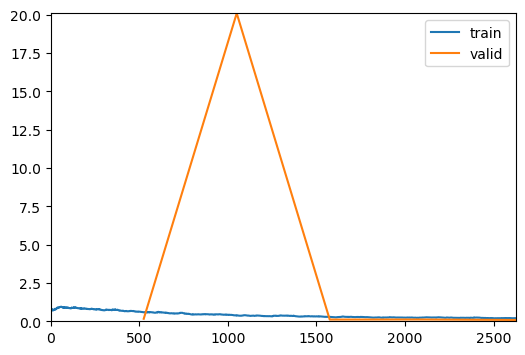

In [ ]:
learn.fine_tune(5, 0.001, cbs= [ShowGraphCallback()])

In [ ]:
# Garbage collection
try:
    del head
    del original_model
    del model
    del Encoder
    del learn
except:
    pass
gc.collect()

### Model using IM2ELEVATION weights (custom head)
- Custom head
- Freeze up to R1

In [ ]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


In [ ]:
# ssl to facilitate downloading of weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

_IncompatibleKeys(missing_keys=['R2.head.2.weight', 'R2.head.2.bias', 'R2.head.2.running_mean', 'R2.head.2.running_var', 'R2.head.4.weight', 'R2.head.6.weight', 'R2.head.6.bias', 'R2.head.6.running_mean', 'R2.head.6.running_var', 'R2.head.8.weight'], unexpected_keys=[])

In [ ]:
# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

#### Check Model Sanity

In [ ]:
test_batch = dls_3.one_batch()[0]

In [ ]:
model.eval()

with torch.no_grad():
    preds = model(test_batch.cpu())
    # print(mse_weighted(preds, dls_3.one_batch()[1].cpu()))

RuntimeError: running_mean should contain 432 elements not 576

In [ ]:
with torch.no_grad():
    preds_trains = tensor([])
    for i in range(len(x_train)):
        x_train_cur = tensor(x_train[i, 1:4]).detach().clone().unsqueeze(0)
        preds_train = tensor(model(x_train_cur.cuda())).cpu()
        preds_trains = torch.cat([preds_trains, preds_train], 0)
    # preds_val = preds_val.cat([preds_val, tensor(model(tensor(x_val[len(x_val)//2:, 1:4])))], dim= 0)
    print(preds_trains.shape)

#### Train Model

In [ ]:
# Need better loss due to scale difference
learn = Learner(dls_3, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

In [ ]:
# learn.summary()

In [ ]:
learn.validate()

(#9) [0.8867355585098267,9.693138991589871,14.907220814446914,3.999553034160294,30628.60781939107,60.012514218551345,24.97207600820401,0.3469476426242126,0.48256466554047545]

SuggestedLRs(valley=6.30957365501672e-05)

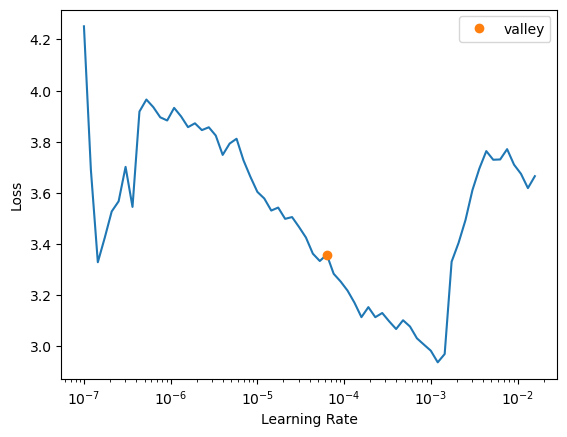

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,3.432986,1.093675,9.241655,14.993688,4.144549,30628.314879,60.671903,24.892997,0.468037,0.306145,00:31
1,3.090733,7.818667,7.816628,12.571094,5.533973,30628.234351,57.598555,21.926296,0.689163,1.806707,00:31
2,2.375539,0.870623,8.099042,11.745920,4.410014,30628.753598,60.198210,20.148400,0.312017,0.518837,00:31


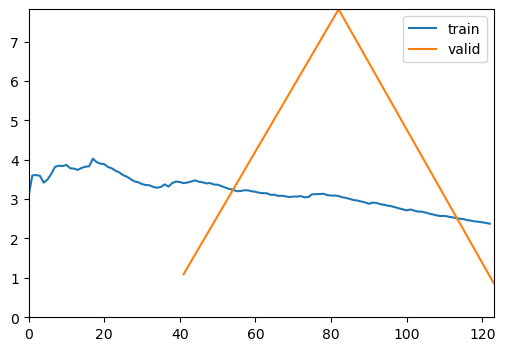

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.429236,0.870859,7.715553,10.959555,4.008010,30628.007502,58.229614,19.424050,0.312629,0.325529,00:31
1,1.353400,0.395066,6.189963,9.135766,3.621193,30627.943492,57.135623,17.076249,0.232834,0.292885,00:31
2,1.180253,0.752621,8.167674,12.430994,4.369593,30628.098606,60.341961,21.220691,0.365312,0.349973,00:31
3,1.007479,0.820718,8.286046,12.131993,4.229866,30628.356677,60.019510,20.522582,0.405826,0.187851,00:31
4,0.928471,0.426236,8.489111,12.925801,3.941933,30628.377175,60.000933,22.624245,0.208512,0.414889,00:31
5,0.730971,0.375744,7.843852,12.310549,3.273444,30628.508192,59.932206,22.829568,0.152484,0.464825,00:31
6,0.661663,0.332308,7.539640,11.938540,3.012248,30628.244533,59.492149,21.926338,0.207022,0.294301,00:31
7,0.601907,0.421370,6.546845,10.805701,2.607445,30628.321824,57.948466,20.980580,0.210765,0.428201,00:31
8,0.536547,0.422869,6.278968,10.556104,2.474701,30628.313721,57.770569,20.791365,0.212971,0.427639,00:31
9,0.534503,0.371049,6.023146,10.319571,2.357346,30628.295974,57.484315,20.561382,0.168100,0.452918,00:31


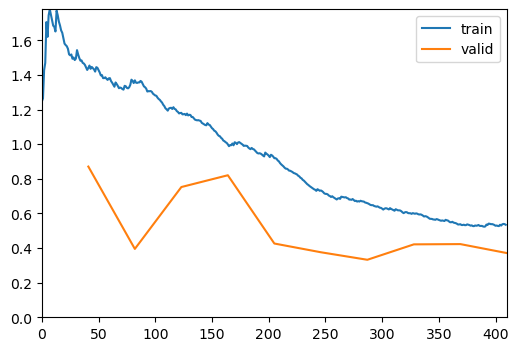

In [ ]:
learn.fine_tune(10, 0.001, freeze_epochs= 3, cbs= [ShowGraphCallback()]) # 40

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.544482,0.427020,6.077025,10.366116,2.920068,30628.320893,57.996417,20.424459,0.234129,0.378195,00:31
1,0.490197,1.504990,3.693027,9.009898,5.893716,30627.302537,50.042316,18.723074,0.420109,0.735098,00:31
2,0.503783,31.798737,10.761887,46.032357,3.612231,30624.638147,51.768096,97.613795,2.019241,2.440639,00:31
3,0.414320,1.047404,17.997219,22.658277,17.484753,30629.114689,31.338280,17.980421,0.308018,0.590830,00:31
4,0.371581,0.698759,21.801555,33.072802,18.270377,30629.063596,29.545363,30.427543,0.120494,0.468159,00:31
5,0.325305,0.778468,22.930785,38.519889,19.625818,30629.114245,31.815544,36.878926,0.061090,0.553200,00:31
6,0.306618,0.730760,22.869202,40.598619,17.757474,30628.987693,36.184855,42.139563,0.074362,0.515858,00:31
7,0.262743,0.923119,26.584315,48.786049,21.036949,30629.147470,46.018353,52.583257,0.074283,0.515928,00:31
8,0.234133,1.230991,28.916804,52.317876,23.087971,30629.128124,50.555404,56.463483,0.164895,0.612410,00:31
9,0.206891,1.105035,28.316375,51.426974,22.416623,30629.085254,49.827935,55.733462,0.138131,0.559441,00:31


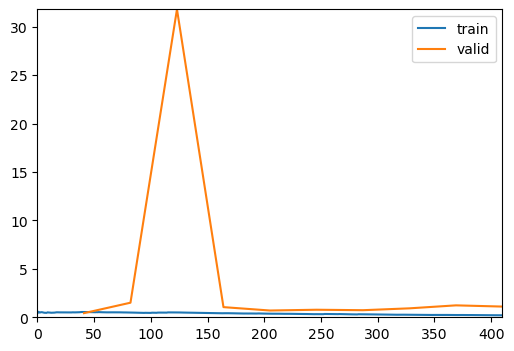

In [ ]:
learn.fit_one_cycle(10, 0.001, cbs= [ShowGraphCallback()]) # 20

In [ ]:
# Plateaus around 30
name = "oldsigmoid_64_20" # <description>_<batch_size>_<epochs>
torch.save(model.state_dict(), f"trained_models/model_weight_{name}.pth")
torch.save(model, f"trained_models/model_{name}.pth")

with open(f"trained_models/model_records_{name}.pkl", "wb") as f:
    pickle.dump(learn.recorder.values, f)

,Train Loss,Val Loss
0,0.544482,0.427020
1,0.490197,1.504990
2,0.503783,31.798737
3,0.414320,1.047404
4,0.371581,0.698759
5,0.325305,0.778468
6,0.306618,0.730760
7,0.262743,0.923119
8,0.234133,1.230991
9,0.206891,1.105035


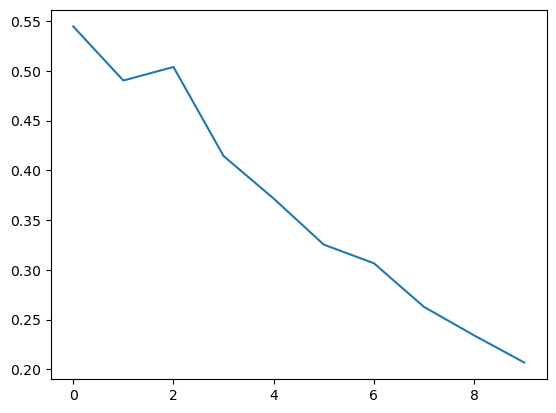

In [ ]:
# Plot loss
with open(f"trained_models/model_records_{name}.pkl", "rb") as f:
    records = pickle.load(f)
sns.lineplot(x= range(len(records)), y= np.array(records)[:, 0])
# sns.lineplot(x= range(len(records)), y= np.array(records)[:, 1])
pd.DataFrame({"Train Loss": np.array(records)[:, 0], "Val Loss": np.array(records)[:, 1]})

,Train Loss,Val Loss
0,0.509622,0.544482
1,0.619999,0.490197
2,1.077759,0.503783
3,0.776177,0.414320
4,0.625814,0.371581
5,0.558939,0.325305
6,0.530189,0.306618
7,0.512992,0.262743
8,0.502269,0.234133
9,0.495738,0.206891


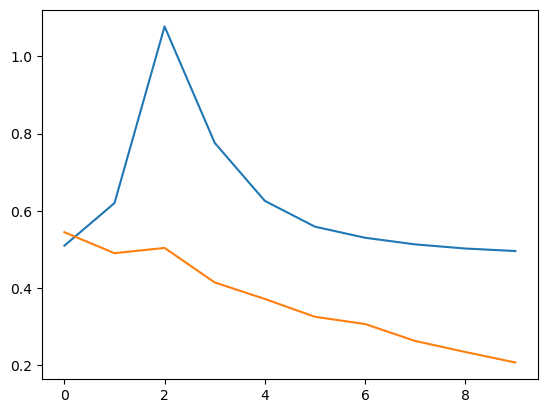

In [ ]:
# Compare loss
name_1 = "sigmoid_64_20"
name_2 = "oldsigmoid_64_20"
with open(f"trained_models/model_records_{name_1}.pkl", "rb") as f:
    records_1 = pickle.load(f)
with open(f"trained_models/model_records_{name_2}.pkl", "rb") as f:
    records_2 = pickle.load(f)
sns.lineplot(x= range(len(records_1)), y= np.array(records_1)[:, 0])
sns.lineplot(x= range(len(records_2)), y= np.array(records_2)[:, 0])
pd.DataFrame({"Train Loss": np.array(records_1)[:, 0], "Val Loss": np.array(records_2)[:, 0]})

In [ ]:
# Garbage collection

# del head
del original_model
del model
del Encoder
del learn

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
del dls_3

In [ ]:
gc.collect()
torch.cuda.empty_cache()

### Model using custom weights (12 channels)
- Using weights from previous model
- Expand model to accept 12 channels instead of just 3

In [16]:
# Load weights from IM2ELEVATION and delete unnecessary layers
checkpoint = torch.load(CHECKPT_PATH)

to_delete = []
for layer in checkpoint["state_dict"].keys():
    if any([word in layer.upper() for word in ["HARM", "R.CONV4", "R.BN4"]]):
    # if any([word in layer.upper() for word in ["HARM", "R.CONV3", "R.BN3", "R.CONV4", "R.BN4"]]):
        to_delete.append(layer)
print(to_delete)

for i in to_delete:
    checkpoint["state_dict"].pop(i)

# Load Weights
ssl._create_default_https_context = ssl._create_unverified_context

original_model = senet.senet154()

Encoder = modules.E_senet(original_model, x_norms)
model = net.model(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])

# Load trimmed im2elevation weights
model.load_state_dict(checkpoint["state_dict"], strict=False)

# Clear memory
del checkpoint
gc.collect()
torch.cuda.empty_cache()

['E.Harm.dct', 'E.Harm.weight', 'E.Harm.bias', 'R.conv4.weight', 'R.conv4.bias']


#### Merging the channels

To merge the channels, the inputs are put to run in parallel until around the mid-way point of the senet backbone, before merging them...?

In [17]:
model = net.model_n12(Encoder, num_features=2048, block_channel = [256, 512, 1024, 2048])
# merged_model = convert_network(model, torch.float16)

### Check Model Sanity

In [ ]:
test_batch = dls_12.one_batch()[0]
test_batch.shape

torch.Size([8, 12, 91, 91])

In [17]:
test_batch_2 = tensor(np.array([i[0] for i in dls_12.train_ds]))
test_batch_2_y = tensor(np.array([i[1] for i in dls_12.train_ds]))

In [ ]:
merged_model.eval()
merged_model.cuda()
merged_model(test_batch).shape

torch.Size([8, 8])

In [19]:
# Load problem x?
with open("logs/x1.pkl", "rb") as f:
    x = pickle.load(f)

merged_model.eval()
merged_model(x.cpu())

TensorBase([[ 0.1637,  0.0986, -0.0395, -0.0691, -0.1730, -0.0662,  0.1068,
             -0.0262],
            [ 0.1629,  0.0980, -0.0387, -0.0688, -0.1735, -0.0651,  0.1064,
             -0.0262],
            [ 0.1625,  0.0976, -0.0398, -0.0704, -0.1745, -0.0644,  0.1049,
             -0.0236],
            [ 0.1627,  0.0977, -0.0391, -0.0691, -0.1742, -0.0650,  0.1060,
             -0.0266],
            [ 0.1646,  0.0997, -0.0388, -0.0676, -0.1723, -0.0670,  0.1077,
             -0.0278],
            [ 0.1637,  0.0982, -0.0393, -0.0689, -0.1729, -0.0658,  0.1071,
             -0.0262],
            [ 0.1637,  0.0986, -0.0390, -0.0686, -0.1733, -0.0666,  0.1072,
             -0.0268],
            [ 0.1638,  0.0989, -0.0391, -0.0683, -0.1729, -0.0663,  0.1072,
             -0.0267]], grad_fn=<AliasBackward0>)

In [18]:
merged_model.eval()
merged_model.cuda()
for batch in range(0, len(test_batch_2), 8):
    preds = merged_model(test_batch_2[batch:min(batch+8, len(test_batch_2))].cuda())
    if mse_weighted(preds, test_batch_2_y[batch:min(batch+8, len(test_batch_2))].cuda()).isnan().sum() > 0:
        print(batch)
        break

In [21]:
merged_model.cuda()
merged_model(tensor(dls_12.train_ds[0][0]).unsqueeze(0).cuda()).shape

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 432])

In [43]:
merged_model.cuda()
for i in dls_12.train_ds:
    if merged_model(tensor(i[0]).unsqueeze(0).cuda()).isnan().sum() > 0:
        print(i)
        print(merged_model(i[0]))
        break

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 432])

### Train Model

In [18]:
# Need better loss due to scale difference
# learn = Learner(dls_12, merged_model, loss_func= mse_weighted, metrics= metrics)
learn = Learner(dls_12, model, loss_func= mse_weighted, metrics= metrics, cbs=[MixedPrecision, FP16TestCallback])

SuggestedLRs(valley=0.00019054606673307717)

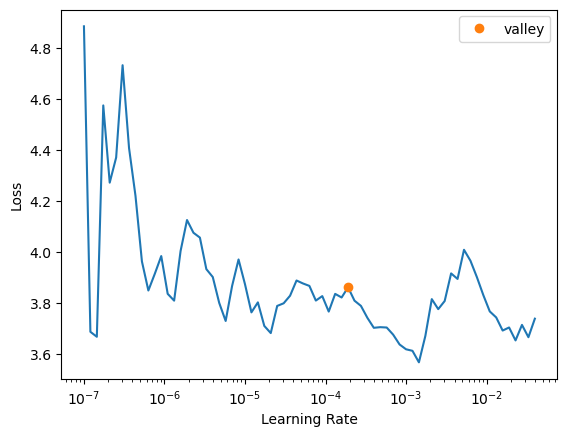

In [36]:
learn.lr_find()

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,1.366890,10.218493,10.232885,18.338076,4.710033,22232.190308,61.842902,31.304233,0.866774,0.653567,03:52


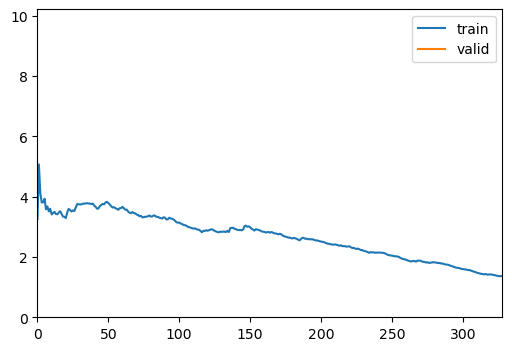

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.778249,11.822211,8.884027,18.450155,6.357875,22233.167346,66.581416,31.898599,1.009521,0.284990,03:51
1,0.524141,605.975403,67.982162,112.815763,67.829097,22183.809798,262.406007,22.610498,5.147591,5.221504,03:47
2,0.364647,0.640605,4.612198,9.508872,2.341330,22233.867696,50.291545,18.732041,0.244909,0.278933,03:40
3,0.273929,0.957175,2.843286,7.001287,3.109090,22234.065890,47.482666,15.221525,0.350471,0.373566,03:38
4,0.194661,0.060562,3.064444,5.961215,2.700709,22234.670347,37.714363,11.451646,0.069642,0.077121,03:35
5,0.158377,0.162754,3.312829,5.408717,2.510564,22234.384211,34.030744,9.736979,0.134499,0.180734,03:33
6,0.138168,0.063264,3.440298,6.798230,1.965048,22234.195450,29.410552,9.381919,0.067451,0.103340,03:32
7,0.122031,0.053639,2.410338,5.155369,1.342771,22234.332191,27.439098,7.963607,0.061748,0.120119,03:33
8,0.098311,0.057761,4.689662,10.487348,2.172056,22233.790546,23.652226,17.361254,0.055470,0.085459,03:35
9,0.099431,0.131000,5.448552,13.292404,1.560960,22232.632420,27.466056,22.370687,0.090981,0.086416,03:34


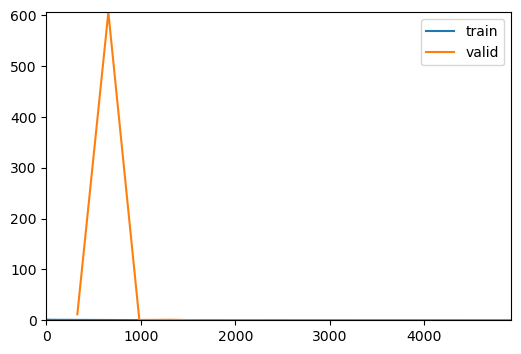

In [19]:
learn.fine_tune(15, 0.001, cbs= [ShowGraphCallback()])

In [38]:
learn.recorder.values

[(#10) [0.7288058400154114,8.911453247070312,17.876080773184775,29.139596633790617,12.111577864797123,22232.165951404528,52.186704242418415,38.118273720910324,1.0821461898761464,0.3911732579805143],
 (#10) [0.4308834969997406,0.11247674375772476,7.05462308907609,12.247037421410731,2.2418793175998797,22234.640760507387,54.6604128395889,21.57347726878896,0.061075722148518655,0.1267113634261034],
 (#10) [0.30299246311187744,1.096637487411499,4.994000342072287,11.193771215336357,4.012040643766953,22233.944339643775,52.22794138327342,22.720532576706667,0.27649410663632745,0.22709349960324357],
 (#10) [0.21371644735336304,0.20453548431396484,4.9122584619093015,11.015084046872495,1.397389905206989,22234.240143880263,51.37033003834661,22.28742907113181,0.12378502902403785,0.10678085712069871],
 (#10) [0.20051045715808868,0.06221893057227135,3.551055737228283,9.049091699435712,1.381469091773985,22234.65032296233,49.692648732080386,18.6893763545585,0.046040689409164934,0.062155700644407674]]

epoch,train_loss,valid_loss,height_avg_bld_rmse,height_avg_area_rmse,height_avg_total_rmse,height_std_rmse,height_max_rmse,height_percentile_rmse,planar_index_rmse,frontal_index_rmse,time
0,0.129933,0.106250,5.227592,11.885707,3.505898,22234.145476,37.134668,22.406620,0.085722,0.141816,03:42
1,0.171544,0.172245,7.793394,17.445271,6.694410,22233.787504,65.809731,32.261235,0.053809,0.167751,03:40
2,0.125990,0.403674,14.013357,30.807621,10.715966,22232.480880,103.097283,53.538962,0.091228,0.142016,03:40
3,0.085266,0.430358,11.529402,25.703384,9.565012,22232.627606,99.930852,46.313500,0.101814,0.323260,03:39
4,0.084238,0.363351,10.098910,22.909432,8.823428,22232.726577,94.197871,41.493255,0.079597,0.322659,03:38


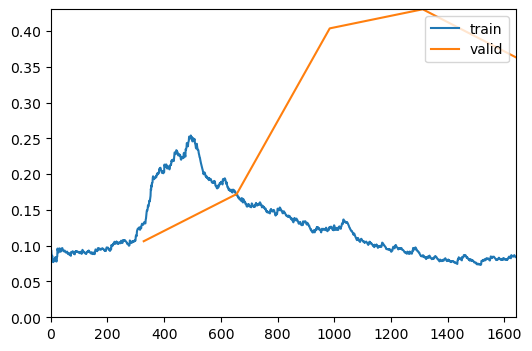

In [42]:
learn.fit_one_cycle(5, 0.001, cbs= [ShowGraphCallback()])

In [20]:
# Plateaus around 30
name = "12ch_8_15" # <description>_<batch_size>_<epochs>
torch.save(model.state_dict(), f"trained_models/model_weight_{name}.pth")
torch.save(model, f"trained_models/model_{name}.pth")

with open(f"trained_models/model_records_{name}.pkl", "wb") as f:
    pickle.dump(learn.recorder.values, f)

,Train Loss,Val Loss
0,0.129933,0.106250
1,0.171544,0.172245
2,0.125990,0.403674
3,0.085266,0.430358
4,0.084238,0.363351


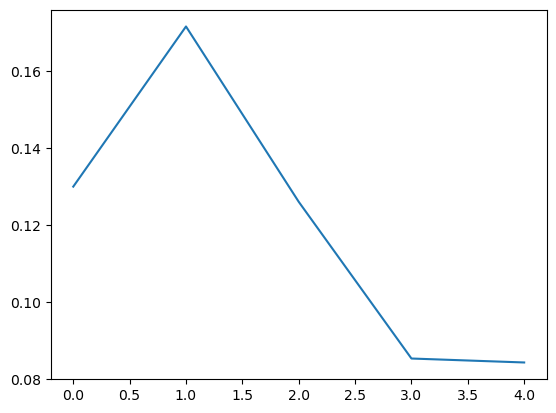

In [44]:
# Plot loss
with open(f"trained_models/model_records_{name}.pkl", "rb") as f:
    records = pickle.load(f)
sns.lineplot(x= range(len(records)), y= np.array(records)[:, 0])
# sns.lineplot(x= range(len(records)), y= np.array(records)[:, 1])
pd.DataFrame({"Train Loss": np.array(records)[:, 0], "Val Loss": np.array(records)[:, 1]})

,Train Loss,Val Loss
0,0.509622,0.544482
1,0.619999,0.490197
2,1.077759,0.503783
3,0.776177,0.414320
4,0.625814,0.371581
5,0.558939,0.325305
6,0.530189,0.306618
7,0.512992,0.262743
8,0.502269,0.234133
9,0.495738,0.206891


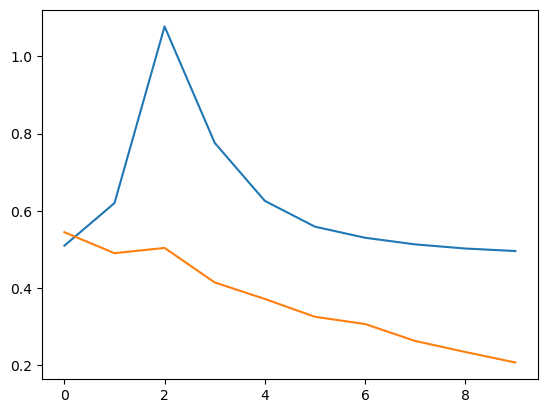

In [ ]:
# Compare loss
name_1 = "sigmoid_64_20"
name_2 = "oldsigmoid_64_20"
with open(f"trained_models/model_records_{name_1}.pkl", "rb") as f:
    records_1 = pickle.load(f)
with open(f"trained_models/model_records_{name_2}.pkl", "rb") as f:
    records_2 = pickle.load(f)
sns.lineplot(x= range(len(records_1)), y= np.array(records_1)[:, 0])
sns.lineplot(x= range(len(records_2)), y= np.array(records_2)[:, 0])
pd.DataFrame({"Train Loss": np.array(records_1)[:, 0], "Val Loss": np.array(records_2)[:, 0]})